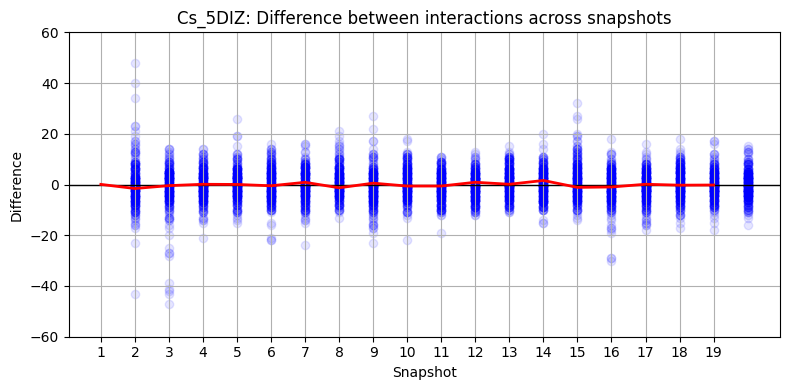

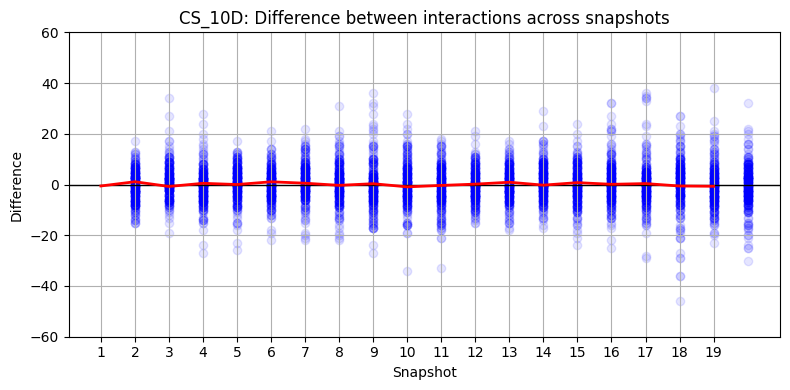

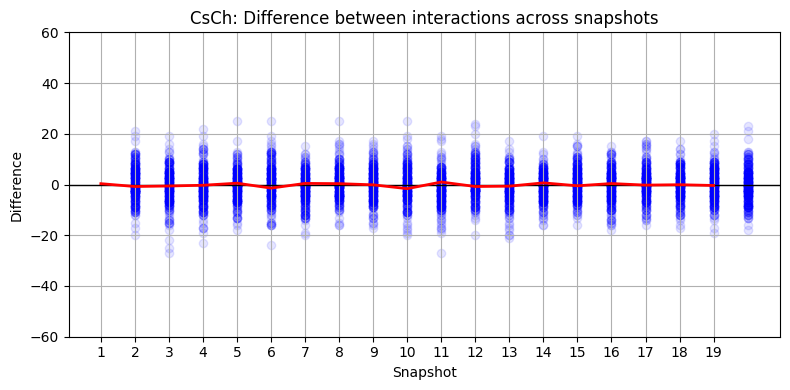

In [7]:
##! TODO add saveimage to report folder

import os, sys
from src import settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import fileio

config = fileio.get_config(settings.CONFIG_NAME)

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "activity_over_time")
os.makedirs(OUTPUT_DIR, exist_ok=True)

TIME_WINDOW = config["TIME_WINDOW"]

for TREATMENT in config["TREATMENTS"]:
    INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")
    treatments_distances = fileio.load_multiple_folders(INPUT_PATH)
    treatments_distances = {key: value for key, value in treatments_distances.items() if key in config["TREATMENTS"]}

    INPUT_PATH = os.path.join(settings.OUTPUT_DIR, "1_0_find_interactions")
    treatments_interactions = fileio.load_multiple_folders(INPUT_PATH)
    treatments_interactions = {
        key: value for key, value in treatments_interactions.items() if key in config["TREATMENTS"]
    }

    treatment_dataframes = []
    for treatment_distance_key, treatment_interactions_key in zip(
        treatments_distances.keys(), treatments_interactions.keys()
    ):
        treatment_distance_path = treatments_distances[treatment_distance_key]
        treatment_interaction_path = treatments_interactions[treatment_interactions_key]

        distance_groups = fileio.load_files_from_folder(treatment_distance_path)
        interaction_groups = fileio.load_files_from_folder(treatment_interaction_path)

        group_dataframes = []
        for distance_tuple, interaction_tuple in zip(distance_groups.items(), interaction_groups.items()):

            distance_group_name, distance_group_path = distance_tuple
            interaction_group_name, interaction_group_path = interaction_tuple

            if distance_group_name != interaction_group_name:
                sys.exit("Group missmatch!")

            df_distance = pd.read_csv(distance_group_path, index_col=0)
            df_distance["Snapshot"] = (df_distance.index / config["FPS"] / TIME_WINDOW).astype(int) + 1

            df_distance = df_distance.melt(id_vars=["Snapshot"], var_name="Fly", value_name="Distance")
            df_distance = df_distance.groupby(["Snapshot", "Fly"]).sum().reset_index()

            df_interaction = pd.read_csv(interaction_group_path, usecols=["node_1", "start_of_interaction"])
            df_interaction["Snapshot"] = (df_interaction.start_of_interaction / config["FPS"] / TIME_WINDOW).astype(
                int
            ) + 1
            df_interaction = (
                df_interaction.groupby(["Snapshot", "node_1"]).size().reset_index(name="Number_of_interactions")
            )
            df_interaction.columns = ["Snapshot", "Fly", "Number_of_interactions"]

            merged_df = pd.merge(df_distance, df_interaction, on=["Snapshot", "Fly"], how="outer")
            merged_df[merged_df.isna().any(axis=1)]
            merged_df.fillna(0, inplace=True)

            merged_df["Group"] = distance_group_name.replace(".csv", "")
            merged_df.set_index("Snapshot", inplace=True)
            merged_df.set_index("Fly", append=True, inplace=True)
            merged_df.set_index("Group", append=True, inplace=True)
            merged_df["Treatment"] = treatment_distance_key
            merged_df.set_index("Treatment", append=True, inplace=True)
            merged_df = merged_df.reorder_levels(["Treatment", "Group", "Snapshot", "Fly"])

            treatment_dataframes.append(merged_df)

    df = pd.concat(treatment_dataframes)

    df_treatmen = df.loc[df.index.get_level_values("Treatment") == TREATMENT]
    df_pivot = df_treatmen.pivot_table(index=["Group", "Fly"], columns="Snapshot", values=["Number_of_interactions"])
    df_pivot.columns = [f"{col[1]}" for col in df_pivot.columns]
    df_pivot = df_pivot.reset_index()

    diff_columns = df_pivot.columns[2:]
    for i in range(len(diff_columns) - 1):
        col_curr = diff_columns[i]
        col_next = diff_columns[i + 1]
        df_pivot[f"{col_next} - {col_curr}"] = df_pivot[col_next] - df_pivot[col_curr]

    df_pivot = df_pivot[
        [
            "2 - 1",
            "3 - 2",
            "4 - 3",
            "5 - 4",
            "6 - 5",
            "7 - 6",
            "8 - 7",
            "9 - 8",
            "10 - 9",
            "11 - 10",
            "12 - 11",
            "13 - 12",
            "14 - 13",
            "15 - 14",
            "16 - 15",
            "17 - 16",
            "18 - 17",
            "19 - 18",
            "20 - 19",
        ]
    ]

    df_pivot.columns = [x for x in range(1, 20)]
    df_transposed = df_pivot.T

    plt.figure(figsize=(8, 4))
    for idx, row in df_transposed.iterrows():
        plt.scatter([idx + 1] * len(row), row, label=f"Snapshot {idx + 1}", alpha=0.1, c="b")

    plt.axhline(y=0, color="black", linestyle="-", linewidth=1)

    mean_values = df_transposed.T.mean()
    plt.plot(mean_values.index, mean_values.values, color="r", linestyle="-", linewidth=2, label="Mean")
    plt.xlabel("Snapshot")
    plt.ylabel("Difference")
    plt.title(f"{TREATMENT}: Difference between interactions across snapshots")
    plt.xticks(range(1, len(df_transposed) + 1))
    plt.ylim(-df.Number_of_interactions.max(), df.Number_of_interactions.max())
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"{TREATMENT}_together.png")
    plt.savefig(save_path)

    plt.show()

Distance  \
Treatment Group                       Snapshot Fly                 
Cs_5DIZ   Cs_5DIZ_01_08_2023_10_10_A1 1        fly1   306.046478   
                                               fly10  203.109629   
                                               fly11  520.240764   
                                               fly12  359.016786   
                                               fly2   142.952921   
...                                                          ...   
CS_10D    CTRL10_29_01_2024_12_32_A4  20       fly5   262.402524   
                                               fly6   437.898556   
                                               fly7   279.186461   
                                               fly8    91.809412   
                                               fly9   210.634586   

                                                      Number_of_interactions  
Treatment Group                       Snapshot Fly                            
Cs_5DIZ   Cs_5DIZ_01_08_2023_10_10_A1 1        fly1                     16.0  
                                               fly10                     4.0  
                                               fly11                     8.0  
                                               fly12                    14.0  
                                               fly2                     17.0  
...                                                                      ...  
CS_10D    CTRL10_29_01_2024_12_32_A4  20       fly5                     28.0  
                                               fly6                     20.0  
                                               fly7                     23.0  
                                               fly8                     29.0  
                                               fly9                     31.0  

[14400 rows x 2 columns]